#Single-stage detection networks

Spre deosebire de o rețea two-stage, în care împărțirea imaginii de input în regiuni reprezintă un pas separat al inferenței, o rețea de detecție single-stage realizează simultan task-urile de împărțire în regiuni, de clasificare și de localizare a obiectelor din imagine.

**Avantaj:** detecție rapidă, potrivită pentru inferență în timp real.

**Dezavantaj:** precizia poate fi mai scăzută la obiecte mici sau în scene complexe.

---

###**YOLO** (You only look once)

YOLO procesează imaginea împărțind-o într-o grilă de dimensiune fixă. Pentru fiecare celulă din grilă, rețeaua prezice probabilitățile claselor și un set prestabilit de bounding boxes, fiecare însoțit de un scor de încredere. În consecință, predicția asociată unei celule are forma:

$$
(x_1, y_1, w_1, h_1, C_1, \; x_2, y_2, w_2, h_2, C_2, \; \dots, \; x_B, y_B, w_B, h_B, C_B, \; p(c_1), p(c_2), \dots, p(c_C))
$$

unde:
- $ (x_i, y_i) $ — coordonatele centrului box-ului relativ la celulă,
- $ (w_i, h_i) $ — lățimea și înălțimea box-ului (raportate la întreaga imagine),
- $ C_i $ — scorul de **încredere** pentru box-ul $i$,
- $ p(c_j) $ — probabilitatea apariției clasei $c_j$ dacă în celulă există un obiect.


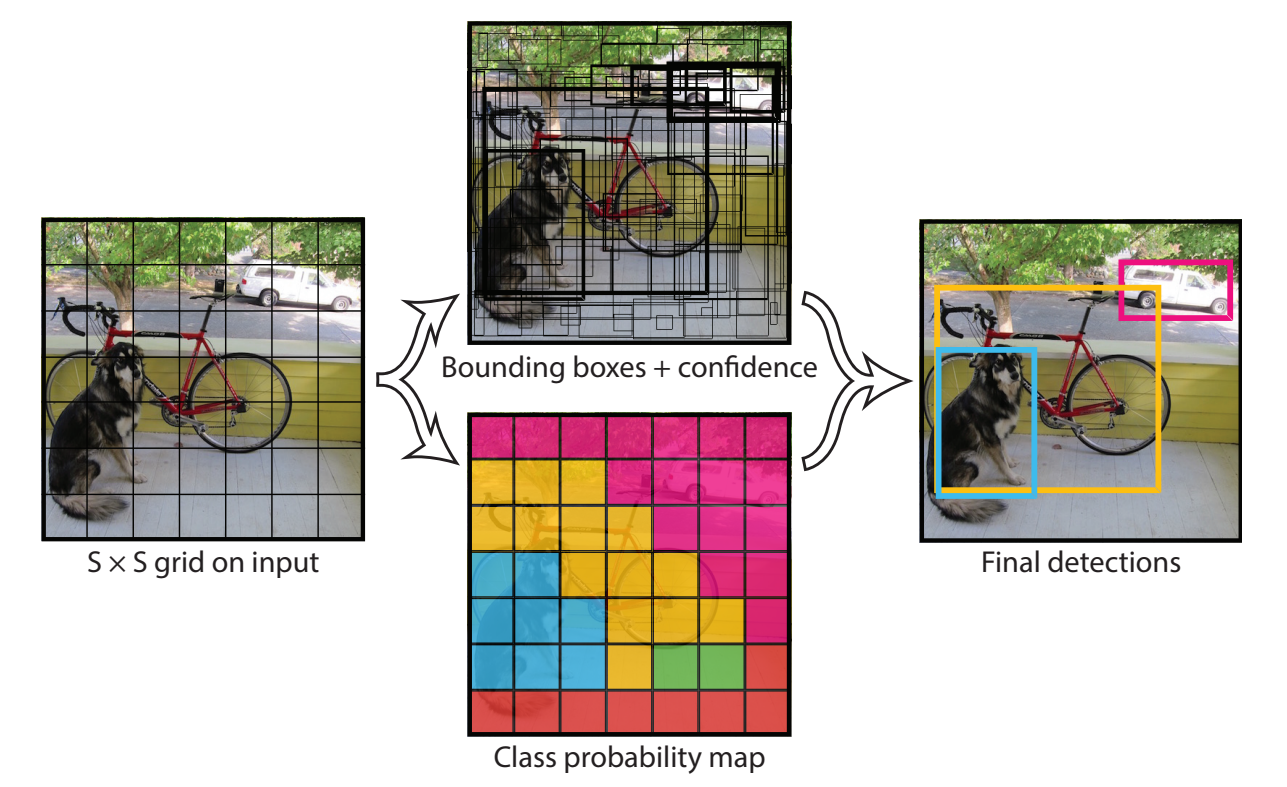




### Arhitectura YOLO

Modelul constă din:
*   24 de straturi convoluționale, pentru extragerea caracteristicilor vizuale
*   2 straturi complet conectate (fully connected), care transformă aceste caracteristici în predicții de bounding boxes și clase.

Funcțiile de activare folosite sunt Leaky ReLU, iar normalizarea se face prin batch normalization pentru stabilitatea antrenării.
Ultimul strat folosește o activare lineară, deoarece trebuie să producă valori continue pentru coordonate și scoruri.

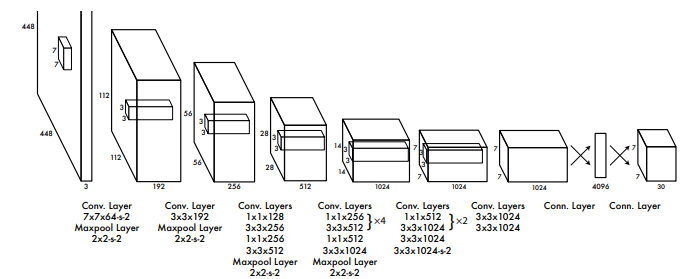

###Loss function
  
Loss function-ul YOLO combină trei componente: localizare, încredere și clasificare:

$$
\
L = \lambda_{coord} L_{coord} + L_{conf} + L_{class}
\
$$

unde:


- $L_{coord}$ — eroarea de **localizare** (pentru poziția și dimensiunea box-urilor),
- $L_{conf}$ — eroarea de **încredere** (confidence score),
- $L_{class}$ — eroarea de **clasificare** (tipul obiectului).

#### **Eroarea de localizare**

Această parte măsoară cât de bine sunt prezise pozițiile și dimensiunile obiectelor.

$$
L_{coord} =
\sum_{i=0}^{S^2}\sum_{j=0}^{B}
\mathbb{1}_{ij}^{obj}
\Big[
(x_i - \hat{x}_i)^2 +
(y_i - \hat{y}_i)^2 +
(\sqrt{w_i} - \sqrt{\hat{w}_i})^2 +
(\sqrt{h_i} - \sqrt{\hat{h}_i})^2
\Big]
$$

Explicații:
- $\mathbb{1}_{ij}^{obj} = 1$ dacă obiectul este detectat de box-ul *j* din celula *i*.
- Se folosește rădăcina pătrată pentru $w$ și $h$ pentru a reduce efectul obiectelor mari.
- $\lambda_{coord} = 5$ dă o importanță mai mare coordonatelor.

#### **Eroarea de încredere (Confidence Loss)**

YOLO prezice pentru fiecare box un **scor de încredere**:

$$
\text{Confidence} = \text{Pr(object)} \times \text{IoU(pred, truth)}
$$

Funcția de pierdere pentru încredere este:

$$
L_{conf} =
\sum_{i=0}^{S^2}\sum_{j=0}^{B}
\Big[
\mathbb{1}_{ij}^{obj} (C_i - \hat{C}_i)^2 +
\lambda_{noobj} \mathbb{1}_{ij}^{noobj} (C_i - \hat{C}_i)^2
\Big]
$$

unde:
- $\lambda_{noobj} = 0.5$ reduce penalizarea pentru box-urile fără obiecte.
- Acest termen învață modelul **unde să fie sigur** și **unde să fie rezervat**.

#### **Eroarea de clasificare**

În fiecare celulă care conține un obiect, YOLO prezice un vector de probabilități pentru clase.

$$
L_{class} =
\sum_{i=0}^{S^2}
\mathbb{1}_{i}^{obj}
\sum_{c=1}^{C}
(p_i(c) - \hat{p}_i(c))^2
$$

unde:
- $p_i(c)$ = eticheta reală (1 pentru clasa corectă, 0 altfel),
- $\hat{p}_i(c)$ = probabilitatea prezisă de model.

Această parte îl învață **ce fel de obiect** se află într-o celulă.

---

### Evoluția modelului YOLO

YOLOv1 a fost revoluționar pentru că a tratat detecția de obiecte ca o singură problemă de regresie. Totuși, modelul era destul de imprecis pentru obiectele mici sau apropiate.

#### Introducerea ancorelor și detectării multi-scale
Primele upgrade-uri au adăugat:
- **Anchor boxes:** învățarea formelor și dimensiunilor tipice ale obiectelor.  
- **Feature pyramids:** detecție la mai multe scale, pentru a recunoaște obiecte mici, mari și medii.

Aceste modificări au crescut considerabil acuratețea și flexibilitatea modelului.

#### Backbone-uri mai puternice și normalizare mai bună
- În timp, YOLO a trecut de la arhitecturi simple (precum GoogLeNet) la rețele avansate: Darknet-19 / 53, apoi CSPDarknet, și mai recent EfficientBackbone. Acestea au îmbunătățit semnificativ capacitatea de extragere a caracteristicilor vizuale.
- Totodată, s-au adăugat tehnici precum Batch Normalization, LeakyReLU, și residual connections, care stabilizează antrenarea.

#### De la YOLO clasic la modele moderne
Începând cu YOLOv5–YOLOv8, modelele au fost complet rescrise în **PyTorch**, devenind:
- mai rapide,
- mai ușor de antrenat pe GPU,
- mai compatibile cu formate moderne (ONNX, TensorRT etc.)

#### YOLOv10–YOLOv11: eficiență maximă și precizie ridicată
Versiunile recente au adus:
- Non-max supression (NMS) îmbunătățit și algoritmi fără NMS (mai stabili la obiecte apropiate).  
- Suport pentru detecție, segmentare, tracking și clasificare într-un singur framework.
- Optimizare pentru dispozitive edge (mobil, Jetson, etc.), cu modele mai mici și rapide (ex: YOLOv11n).

---


### Demo code (fine-tune și inferență)

Pachetul **ultralytics** conține implementări pentru multiple versiuni de YOLO.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.0 MB/s eta 0:00:00


În aces demo vom folosi dataset-ul **Oxford-IIIT-Pet**.

In [ ]:
from torchvision.datasets import OxfordIIITPet

dataset = OxfordIIITPet(root="data", download=True)

100%|██████████| 792M/792M [00:34<00:00, 22.8MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 12.0MB/s]


Pentru a folosi dataset-ul în antrenarea modelului, e nevoie de convertirea formatului bounding box-urilor și crearea unei configurații .yaml

In [ ]:
import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from PIL import Image

DATASET_DIR = "data/oxford-iiit-pet"
IMAGES_DIR = os.path.join(DATASET_DIR, "images")
ANNOTATIONS_DIR = os.path.join(DATASET_DIR, "annotations/xmls")

YOLO_IMAGES_DIR = os.path.join(DATASET_DIR, "images")
YOLO_LABELS_DIR = os.path.join(DATASET_DIR, "labels")

VAL_SPLIT = 0.2
SEED = 42

image_files = [f.split(".")[0] for f in os.listdir(ANNOTATIONS_DIR) if f.endswith(".xml")]

train_files, val_files = train_test_split(image_files, test_size=VAL_SPLIT, random_state=SEED)

def convert_box(size, box):
    """Convert (xmin, xmax, ymin, ymax) box to YOLO format (x_center, y_center, w, h)."""
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def process_files(files, split):
    out_img_dir = os.path.join(YOLO_IMAGES_DIR, split)
    out_lbl_dir = os.path.join(YOLO_LABELS_DIR, split)

    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    for name in files:
        xml_path = os.path.join(ANNOTATIONS_DIR, name + ".xml")
        img_path = os.path.join(IMAGES_DIR, name + ".jpg")
        out_img_path = os.path.join(out_img_dir, name + ".jpg")
        out_lbl_path = os.path.join(out_lbl_dir, name + ".txt")

        if not os.path.exists(xml_path) or not os.path.exists(img_path):
            continue

        if not os.path.exists(out_img_path):
            os.system(f"cp '{img_path}' '{out_img_path}'")

        tree = ET.parse(xml_path)
        root = tree.getroot()

        size = root.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        with open(out_lbl_path, "w") as f:
            for obj in root.iter("object"):
                cls = obj.find("name").text.lower().strip()

                cls_id = CLASSES.index(cls)

                xmlbox = obj.find("bndbox")
                b = (int(xmlbox.find("xmin").text), int(xmlbox.find("xmax").text),
                     int(xmlbox.find("ymin").text), int(xmlbox.find("ymax").text))
                bb = convert_box((w, h), b)
                f.write(f"{cls_id} " + " ".join([f"{a:.6f}" for a in bb]) + "\n")

CLASSES = []
for xml_file in os.listdir(ANNOTATIONS_DIR):
    if not xml_file.endswith(".xml"):
        continue
    tree = ET.parse(os.path.join(ANNOTATIONS_DIR, xml_file))
    root = tree.getroot()
    for obj in root.iter("object"):
        cls = obj.find("name").text.lower().strip()
        if cls not in CLASSES:
            CLASSES.append(cls)

CLASSES = sorted(CLASSES)
print(f"Found {len(CLASSES)} classes.")

process_files(train_files, "train")
process_files(val_files, "val")

yaml_path = os.path.join(DATASET_DIR, "oxford-iiit.yaml")
with open(yaml_path, "w") as f:
    f.write("path: " + DATASET_DIR + "\n")
    f.write("train: images/train\n")
    f.write("val: images/val\n")
    f.write("names:\n")
    for i, clss in enumerate(CLASSES):
        f.write(f"  {i}: {clss}\n")

print("Dataset ready for YOLOv11.")


Found 2 classes.
Dataset ready for YOLOv11.


Demo-ul va fi făcut folosind varianta YOLOv11n (nano). Urmează inițializarea modelului cu weight-uri pretrained. Vom face fine-tune pe dataset-ul pe care l-am descărcat și pregătit.

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

results = model.train(data=yaml_path, epochs=10)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.206 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/oxford-iiit-pet/oxford-iiit.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7

În urma antrenării a fost creat un fișier .pt, ce conține weight-urile obținute prin fine-tuning.

In [ ]:
WEIGTHS_FILE = "runs/detect/train/weights/best.pt"

model = YOLO(WEIGTHS_FILE)

Acum putem rula inferențe cu modelul fine-tuned.


image 1/1 /content/data/oxford-iiit-pet/images/american_bulldog_169.jpg: 448x640 1 dog, 80.4ms
Speed: 3.6ms preprocess, 80.4ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)


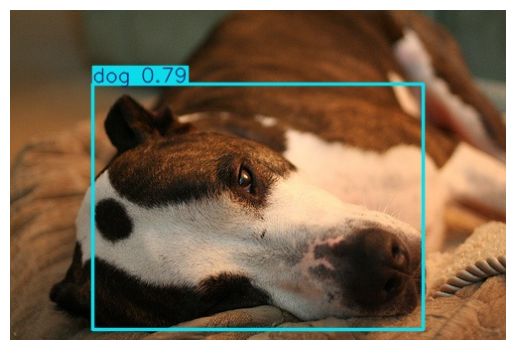

In [ ]:
import matplotlib.pyplot as plt

IMG_FILE = "american_bulldog_169.jpg"

results = model(os.path.join(IMAGES_DIR, IMG_FILE))

results[0].save(filename="output.jpg")

img = plt.imread("output.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

Codul de mai jos este o varianta "manuală" de control a rezultatului, accesând direct bounding box-urile și clasele prezise, dar și având opțiunea de a modifica threshold-uri.

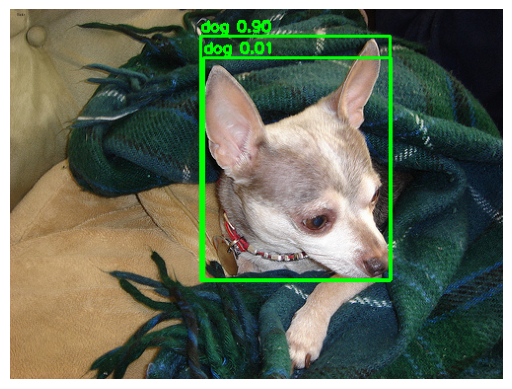

In [ ]:
from torchvision.ops import nms
import cv2

IMG_FILE = "chihuahua_25.jpg"

results = model(os.path.join(IMAGES_DIR, IMG_FILE), conf=0.01, iou=0.95, stream=False, verbose=False)

r = results[0]

# Extragem bbox-urile, confidențele și clasele
boxes = r.boxes.xyxy  # (N, 4) [xmin, ymin, xmax, ymax]
scores = r.boxes.conf  # (N,)
classes = r.boxes.cls  # (N,)

# De aici se poate seta prelucrarea pentru non-max supression
APPLY_NMS = False
if APPLY_NMS:
    keep = nms(boxes, scores, iou_threshold=0.99999) #threshold-ul pentru supression
    boxes = boxes[keep]
    scores = scores[keep]
    classes = classes[keep]

img = cv2.imread(os.path.join(IMAGES_DIR, IMG_FILE))

for box, score, cls in zip(boxes, scores, classes):
    x1, y1, x2, y2 = box.int().tolist()
    label = f"{model.names[int(cls)]} {score:.2f}"
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, label, (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

cv2.imwrite("output_nms.jpg", img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()